In [ ]:
import os
from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torchs
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage

# Define the paths
INPUT_FOLDER = "images/segmented_images"  # Replace with your input folder path
OUTPUT_FOLDER = "output"  # Replace with your output folder path
os.makedirs(OUTPUT_FOLDER, exist_ok=True)  # Create output folder if it doesn't exist

# Define the categories list
cats = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 
        'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 
        'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 
        'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 
        'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 
        'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

# Function to handle different image channels
def fix_channels(t):
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

def idx_to_text(i):
    return cats[i]


COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125], 
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


# Function for bounding box processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes, output_path):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
        cl = p.argmax()
        ax.text(xmin, ymin, idx_to_text(cl), fontsize=10, bbox=dict(facecolor=c, alpha=0.8))
    plt.axis('off')
    plt.savefig(output_path)  # Save the figure to output path
    plt.close()  # Close the figure to avoid display

def visualize_predictions(image, outputs, output_path, threshold=0.8):
    # Keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # Convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    # Plot results
    plot_results(image, probas[keep], bboxes_scaled, output_path)

# Load the feature extractor and model
MODEL_NAME = "valentinafeve/yolos-fashionpedia"
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')
model = YolosForObjectDetection.from_pretrained(MODEL_NAME)

# Process images in the input folder
for filename in os.listdir(INPUT_FOLDER):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Process only image files
        image_path = os.path.join(INPUT_FOLDER, filename)
        output_path = os.path.join(OUTPUT_FOLDER, f"output_{filename}")

        # Load and process the image
        image = Image.open(image_path)
        image = fix_channels(ToTensor()(image))
        image = image.resize((600, 800))

        # Extract features and make predictions
        inputs = feature_extractor(images=image, return_tensors="pt")
        outputs = model(**inputs)

        # Visualize predictions
        visualize_predictions(image, outputs, output_path, threshold=0.5)


In [2]:
import os
import csv

# Define the paths
OUTPUT_FOLDER = "output"  # Replace with your output folder path
CSV_FILE_PATH = os.path.join(OUTPUT_FOLDER, "detected_categories.csv")

# Initialize results list
results = []

# Process images in the output folder
for filename in os.listdir(OUTPUT_FOLDER):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Process only image files
        # Assuming the categories are included in the filename
        # Example: output_shirt_blouse.jpg
        # You may need to adjust the splitting logic based on your filename format
        category_part = filename.split('_')[1:-1]  # Extract categories from filename
        detected_categories = ' '.join(category_part)  # Join categories for CSV

        # Append to results list
        results.append((filename, detected_categories))

# Write results to a CSV file
with open(CSV_FILE_PATH, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'Detected Categories'])  # Header
    for img_name, categories in results:
        writer.writerow([img_name, categories])  # Write each image name and detected categories


In [3]:
import os
import csv
from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage

# Define the paths
INPUT_FOLDER = "input_img"  # Replace with your input folder path
OUTPUT_FOLDER = "output"  # Replace with your output folder path
os.makedirs(OUTPUT_FOLDER, exist_ok=True)  # Create output folder if it doesn't exist

# Define the categories list
cats = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 
        'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 
        'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 
        'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 
        'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 
        'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

# Initialize results list
results = []

# Function to handle different image channels
def fix_channels(t):
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for _ in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for _ in (0, 0, 0)]))
    return ToPILImage()(t)

def idx_to_text(i):
    return cats[i]

# Random colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125], 
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Function for bounding box processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes, output_path):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
        cl = p.argmax()
        ax.text(xmin, ymin, idx_to_text(cl), fontsize=10, bbox=dict(facecolor=c, alpha=0.8))
    plt.axis('off')
    plt.savefig(output_path)  # Save the figure to output path
    plt.close()  # Close the figure to avoid display

def visualize_predictions(image, outputs, output_path, threshold=0.8):
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    # Collect detected categories
    detected_categories = [idx_to_text(p.argmax()) for p in probas[keep]]
    results.append((output_path, detected_categories))  # Store the output path and detected categories

    plot_results(image, probas[keep], bboxes_scaled, output_path)

# Load the feature extractor and model
MODEL_NAME = "valentinafeve/yolos-fashionpedia"
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')
model = YolosForObjectDetection.from_pretrained(MODEL_NAME)

# Process images in the input folder
for filename in os.listdir(INPUT_FOLDER):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Process only image files
        image_path = os.path.join(INPUT_FOLDER, filename)
        output_path = os.path.join(OUTPUT_FOLDER, f"output_{filename}")

        # Load and process the image
        image = Image.open(image_path)
        image = fix_channels(ToTensor()(image))
        image = image.resize((600, 800))

        # Extract features and make predictions
        inputs = feature_extractor(images=image, return_tensors="pt")
        outputs = model(**inputs)

        # Visualize predictions
        visualize_predictions(image, outputs, output_path, threshold=0.5)

# Write results to a CSV file
csv_file_path = os.path.join(OUTPUT_FOLDER, "detected_categories.csv")
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'Detected Categories'])  # Header
    for img_path, categories in results:
        writer.writerow([img_path, ', '.join(categories)])  # Write each image path and detected categories


C:\Users\amish\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [4]:
import csv
import os

# Define the paths
INPUT_CSV_FILE_PATH = "output/detected_categories.csv"  # Replace with your input CSV file path
OUTPUT_CSV_FILE_PATH = os.path.join(os.path.dirname(INPUT_CSV_FILE_PATH), "cleaned_detected_categories.csv")

# Read the input CSV file
with open(INPUT_CSV_FILE_PATH, mode='r', newline='') as input_file:
    reader = csv.reader(input_file)
    header = next(reader)  # Read the header
    data = list(reader)  # Read the rest of the data

# Process the data to remove duplicate categories for each image
cleaned_data = []
for row in data:
    image = row[0]
    categories = row[1].split(', ')
    unique_categories = list(set(categories))  # Remove duplicates
    cleaned_categories = ', '.join(unique_categories)
    cleaned_data.append([image, cleaned_categories])

# Write the cleaned data to a new CSV file
with open(OUTPUT_CSV_FILE_PATH, mode='w', newline='') as output_file:
    writer = csv.writer(output_file)
    writer.writerow(header)  # Write the header
    writer.writerows(cleaned_data)  # Write the cleaned data


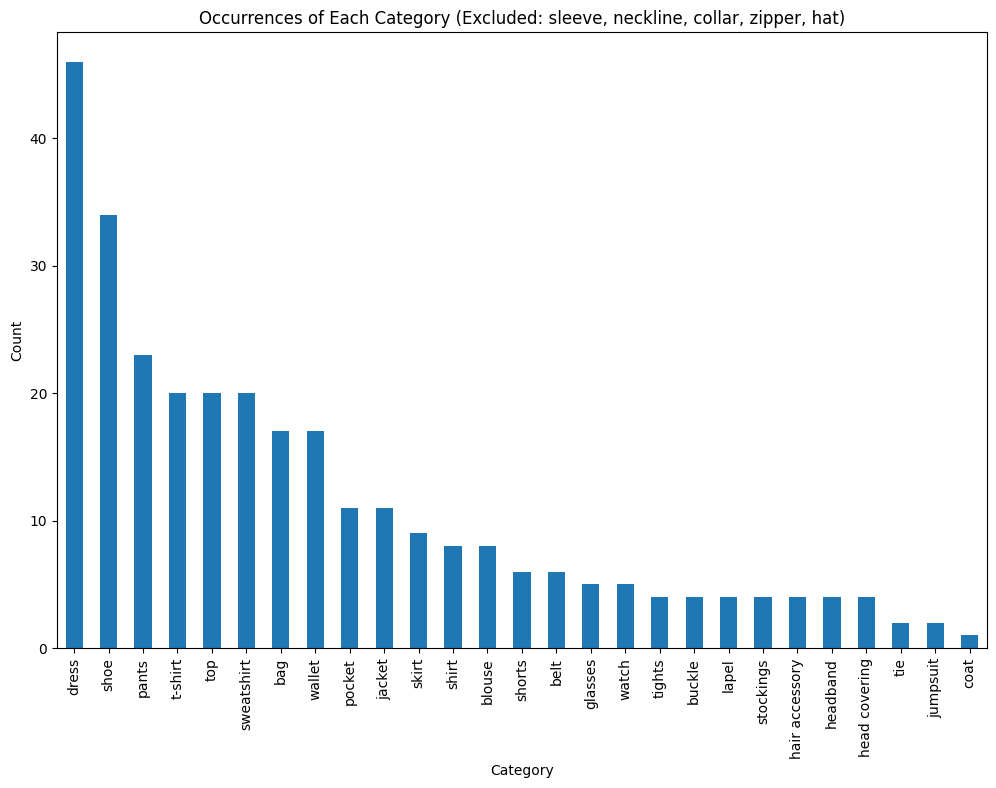

In [14]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the paths
CLEANED_CSV_FILE_PATH = "output/cleaned_detected_categories.csv"  # Replace with your cleaned CSV file path

# Read the cleaned CSV file
df = pd.read_csv(CLEANED_CSV_FILE_PATH)

# Split the categories into a list and explode the DataFrame
df['Detected Categories'] = df['Detected Categories'].str.split(', ')
df_exploded = df.explode('Detected Categories')

# Remove the specified categories
categories_to_remove = ['sleeve', 'neckline', 'collar', 'zipper', 'hat']
df_exploded = df_exploded[~df_exploded['Detected Categories'].isin(categories_to_remove)]

# Count the occurrences of each remaining category
category_counts = df_exploded['Detected Categories'].value_counts()

# Generate a bar plot for category occurrences
plt.figure(figsize=(12, 8))
category_counts.plot(kind='bar')
plt.title('Occurrences of Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



